# Week7 - Decision Tree Lab & HW

## LAB

* Do a quick EDA to understand your data and explain what you need for your pipeline.
* Explain what metric would be appropriate for this task (1 sentence).
* Explain your game plan
* Create a preprocessing pipeline (without the model).


## HW

* Train-test split
* Create 2 new pipelines for the following 2 models and use preprocessing pipeline you created in the previous step
    * a decison tree model https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    * a random forest model https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* Define params for GridSearchCV for both models
* Evaluate the models

* Explain findings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [2]:
# DON'T CHANGE ANYTHING HERE....

random.seed(42)
def remove_values(df, cols, perc=0.001):
    for i in cols:
        mask = pd.Series(random.choices([0,1], weights=[perc, 1-perc], k=len(df[i])))
        df[i] = [ x if i==1 else None for x, i in zip(df[i], mask)]

def create_df(size=1000000):
    from sklearn.datasets import make_classification

    X, y = make_classification(
        n_samples=size,
        n_features=5,
        n_informative=5,
        n_redundant=0,
        n_classes=2,
        flip_y=0.2,
        random_state=4
    )

    df = pd.DataFrame(X)
    df.columns = ['f1', 'f2', 'f3', 'f4', 'f5']
    df.f1 = df.f1**2
    df.f2 = df.f2**2
    df.f3 = df.f3*1000

    flag = random.choices([True, False], weights=[0.65, 0.35], k=len(y))
    f6 = ['A' if i == 0 else 'B' for i in y]

    f6 = [f if i else ('B' if f=='A' else 'A') for i,f in zip(flag, f6)]
    df['f6'] = f6

    remove_values(df, df.columns, perc=0.05)

    return df, pd.Series(y)

X, y = create_df()

In [3]:
#eda code

# 1. Basic Data Exploration
print("Dataset Shape :", X.shape)

Dataset Shape : (1000000, 6)


In [4]:
print(X.head())

         f1         f2           f3        f4        f5 f6
0  3.083178   3.022878  1276.390696 -2.672085  1.085629  B
1       NaN   1.764094  -873.709051  2.084035  0.387268  A
2  8.663599        NaN  -563.461158 -0.044922  2.512673  A
3       NaN   3.899908   753.129656  1.565944 -3.771516  A
4  0.684772  22.623978  -392.739840 -0.136113 -2.028027  A


In [5]:
print("Summary of Dataset")
print(X.describe())

Summary of Dataset
                 f1            f2             f3             f4             f5
count  9.499330e+05  9.498840e+05  949804.000000  950444.000000  950149.000000
mean   2.970269e+00  2.698242e+00       1.203865      -0.002337      -0.000394
std    4.223559e+00  3.863111e+00    1441.308642       1.682211       1.683646
min    7.464873e-15  4.200556e-12   -6319.721066      -8.364699      -7.067953
25%    3.265102e-01  3.144912e-01   -1077.181298      -1.172712      -1.186616
50%    1.415231e+00  1.310581e+00    -403.563631       0.067817       0.001923
75%    3.905995e+00  3.501739e+00    1009.950057       1.156616       1.152483
max    9.069379e+01  8.512300e+01    7402.596849       9.717087       8.354947


<Axes: >

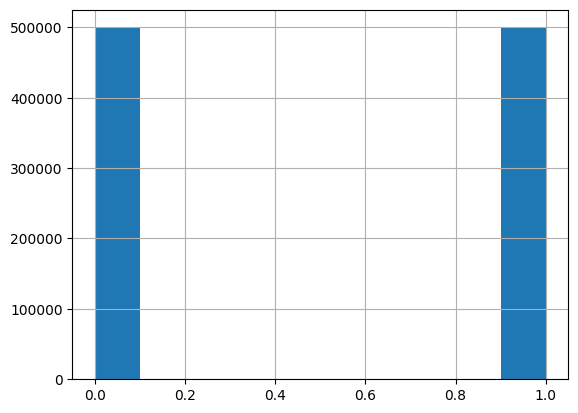

In [6]:
y.hist()

In [7]:
X.isna().sum()

f1    50067
f2    50116
f3    50196
f4    49556
f5    49851
f6    50017
dtype: int64

Explain what metric would be appropriate for this task (1 sentence).

I feel the F1 score would the appropriate for this task as this is a binary classification task. F1 score is a good metric as it provides a good balance measure between precision and recall. 

Explainations...

What do you need for pipeline?

- I can observe that there missing values and column "f6" has categorical values 'A' and 'B'. 

- So I need to do the following for pipeline. 
    - Handling the missing values - using mean, median or mode. 
    - Encoding the categorical feature 'f6' to numerical values.
    - Feature scaling and selection if neccesary
    - And selecting the appropiate model.


Explain your gameplan...

My gameplan is to:

- 1) Create a subset of the existing dataset with balanced features, so that it can be easier for processing and performing gridsearchCV
- 2) Creating a pipeline processor for imputing the missing values and encoding the categorical values.
- 3) Performing the gridsearchCV and find the best performing parameters for both the models.
- 4) Evaluating the model and selecting the best algorithm.

### Creating balanced subset of the dataset

In [8]:
def create_balanced_subset(X, y, size=10000):
    # Separate samples for each class
    class_0_indices = np.where(y == 0)[0]
    class_1_indices = np.where(y == 1)[0]

    # Selecting samples from each class
    balanced_indices = np.concatenate([
        np.random.choice(class_0_indices, size=size//2, replace=False),
        np.random.choice(class_1_indices, size=size//2, replace=False)
    ])

    X_balanced = X.iloc[balanced_indices]
    y_balanced = y.iloc[balanced_indices]

    return X_balanced, y_balanced

X_balanced, y_balanced = create_balanced_subset(X, y)

y_balanced.value_counts()


0    5000
1    5000
Name: count, dtype: int64

In [9]:
#Dropping f6 
X_balanced = X_balanced.drop(columns=['f6'])

### Creating processing pipeline

In [10]:
# create processing pipeline

# Preprocessing pipeline
numeric_features = X_balanced.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_balanced.select_dtypes(include=['object']).columns.tolist()

# Preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combing both numeric and categorical features
processing_pipeline = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

processing_pipeline


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['f1', 'f2', 'f3', 'f4', 'f5']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 [])])

## HW

Train - Test Split

In [11]:
from sklearn.model_selection import train_test_split

# Performing train-test split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (8000, 5) (8000,)
Test set shape: (2000, 5) (2000,)


### Creating Pipelines for both models

## Decision Tree

In [12]:
dt_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', DecisionTreeClassifier())]
)
dt_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('ml', DecisionTreeClassifier())])

In [13]:
dt_param_grid = [
    {
    'ml__max_depth': [None, 5, 10, 15],
    'ml__min_samples_split': [2, 5, 10],
    'ml__min_samples_leaf': [1, 2, 4]
    }
]

scoring ='f1'

dt_gc = GridSearchCV(estimator=dt_modeling_pipeline, param_grid=dt_param_grid, cv=5, scoring=scoring)
dt_gcv_results = dt_gc.fit(X_train, y_train)

In [14]:
dt_gcv_results.best_params_

{'ml__max_depth': 5, 'ml__min_samples_leaf': 1, 'ml__min_samples_split': 2}

In [15]:
dt_gcv_results.score(X_train, y_train)

0.8000496462703238

In [16]:
dt_gcv_results.score(X_test, y_test)

0.7883941970985492

## Random Forest

In [17]:
rf_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', RandomForestClassifier())]
)
rf_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('ml', RandomForestClassifier())])

In [18]:
rf_param_grid = [
    {
    'ml__n_estimators': [100, 200, 300],
    'ml__max_depth': [None, 5, 10, 15],
    'ml__min_samples_split': [2, 5, 10],
    'ml__min_samples_leaf': [1, 2, 4]
    }
]

scoring = 'f1'

rf_gc = GridSearchCV(estimator=rf_modeling_pipeline, param_grid=rf_param_grid, cv=5, scoring=scoring)
rf_gcv_results = rf_gc.fit(X_train, y_train)

In [19]:
rf_gcv_results.best_params_

{'ml__max_depth': 15,
 'ml__min_samples_leaf': 2,
 'ml__min_samples_split': 10,
 'ml__n_estimators': 300}

In [20]:
rf_gcv_results.score(X_train, y_train)

0.8942379645796957

In [21]:
rf_gcv_results.score(X_test, y_test)

0.818969913309536

Explain __shortly__ your findings how did you address the issues.

After performing gridsearchCV, I found out that train accuracy for both Decision Tree and Random Forest are some what similar with only a slight difference. I performed the grid search on subset of data due to memory constraints. However, Random Forest performs better on test accuracy.

Explain which model would you go with?

Based on the above findings, I would go with Random Forest model as it has better performanace in terms of performing on unseen data. This can be observed in the difference of gaps in accuracy. 

While decision tree model's Test accuracy is 76%, Random forest model's test accuracy is 80%. Random Forest model can be useful to reduce overfitting.

In [22]:
# create a new pipeline with the winner model and the best params
# evaluate the same results

rf_best_params = {key.replace('ml__', ''): value for key, value in rf_gcv_results.best_params_.items()}

# Create a new pipeline with the winning model (Random Forest) and best parameters
best_rf_pipeline = Pipeline([
    ('preprocessor', processing_pipeline),
    ('rf', RandomForestClassifier(**rf_best_params))  # Using best parameters
])

In [23]:
X = X.drop(columns=['f6'])

In [24]:
from sklearn.model_selection import train_test_split

# Performing train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (800000, 5) (800000,)
Test set shape: (200000, 5) (200000,)


In [25]:
best_rf_pipeline.fit(X_train, y_train)

y_pred_best_rf = best_rf_pipeline.predict(X_test)

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
precision_best_rf = precision_score(y_test, y_pred_best_rf)
recall_best_rf = recall_score(y_test, y_pred_best_rf)
f1_best_rf = f1_score(y_test, y_pred_best_rf)
conf_matrix_best_rf = confusion_matrix(y_test, y_pred_best_rf)

In [27]:
print("Random Forest Model Evaluation:")
print("Accuracy:", accuracy_best_rf)
print("Precision:", precision_best_rf)
print("Recall:", recall_best_rf)
print("F1 Score:", f1_best_rf)
print("Confusion Matrix:")
print(conf_matrix_best_rf)

Random Forest Model Evaluation:
Accuracy: 0.84208
Precision: 0.8444900092469746
Recall: 0.8390923980345943
F1 Score: 0.841782551196249
Confusion Matrix:
[[84396 15472]
 [16112 84020]]


Explain results

- Results are indicating that Random Forest model is correctly classifying 84.2% instance of test dataset. 
- Precision rate indicates that 84.4% of the instances predicted as positive are truly positive.
- Recall rates shows us that 84% of the times instances are actually positive.
- F1 score is mean of Precision and Recall. Model acheived good balance of 84%

Finally, We can say that model is performing good with high accuracy, precision, recall & F1 score. 